In [285]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using SatellitePlayground
using SatelliteDynamics
using Plots
using LinearAlgebra
SP = SatellitePlayground

  Activating project at `~/Downloads/cmu_classes/16745/final_project`


SatellitePlayground

In [344]:
include("nominal_dynamics.jl")
include("rollout.jl")

generate_jacobians (generic function with 2 methods)

In [414]:
J = SP.default_parameters.J
x0 = SP.initialize_orbit()
x0 = SP.RBState(
    x0.position,
    x0.velocity,
    [1, 0, 0, 0],
    zeros(3)
)

steps = 100
dt = 0.1
(states, times) = rollout(x0, steps, dt)
ref_traj = [
    SP.RBState(
        attitude=x0.attitude,
        angular_velocity=x0.angular_velocity,
        position=state.position,
        velocity=state.velocity
    )
    for state in states
    
]
@time As, Bs = generate_jacobians(ref_traj, times, J, dt)

intialized orbit!
[100/100]: norm(ω)=0.000 r=<-0.001 -6650685.112 -87777.527> b=<4.825 -0.866 28.004> dt=0.100
Simulation complete!
  0.007387 seconds (59.11 k allocations: 9.570 MiB)


(Any[[1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.049999999999999996 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.049999999999999996 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.049999999999999996 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.049999999999999996 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.049999999999999996 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.049999999999999996 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.049999999999999996 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.049999999999999996 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.049999999999999996 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.049999999999999996 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]  …  [1

In [415]:
function hat(ω)
    # TODO: implement the hat function 
    ω̂ = [0 -ω[3] ω[2]
        ω[3] 0 -ω[1]
        -ω[2] ω[1] 0]
    
    return ω̂
end

function L(q)
    # TODO: implement L 
    #_L = zeros(4,4)
    _L = [q[1] -q[2:end]'
        q[2:end] q[1]*I + hat(q[2:end])]
    return _L
end

function R(q)
    # TODO: implement R 
    #_R = zeros(4,4)
    _R = [q[1] -q[2:end]'
        q[2:end] q[1]*I - hat(q[2:end])]
    return _R
end

# TODO: implement H function 
H = zeros(4,3)
H = [0 0 0
    1 0 0
    0 1 0
    0 0 1]

function G(q)
    q_mat = [-q[2] q[1] q[4] -q[3];
             -q[3] -q[4] q[1] q[2];
            -q[4] q[3] -q[2] q[1]]
    _G = [I zeros(3,4);
            zeros(3,3) q_mat]
    return _G
end

G (generic function with 1 method)

In [434]:
N = length(ref_traj) 

# TODO: use TVLQR to generate K's 

# use this for TVLQR tracking cost 
Q_lqr = diagm([1e2,1e2, 1e2,1,1,1])
Qf_lqr = 10*Q_lqr
R_lqr = 1e2*diagm(ones(3))
nu = 3
nx = 13

K = [zeros(nu,nx) for i=1:N-1]
S = [zeros(nx,nx) for i = 1:N]
S[N]=deepcopy(Qf_lqr)
for k = N-1:-1:1
    xk = ref_traj[k]
    qk = xk.attitude
    Gk = G(qk)
    A = Gk*As[k]*Gk'
    B = Gk*Bs[k]
    K[k] = (R_lqr + B'S[k+1] * B) \ (B' * S[k+1] * A)
    S[k] = Q_lqr + K[k]' * R_lqr * K[k] + inv(A - B * K[k]) * A'S[k+1] * (A - B * K[k])
end

In [439]:
function log_state(hist, state)
    push!(hist, state)
end
i = 0
function tvlqr_control(measurement)
    (state, _) = measurement
    global i
    i+=1
    traj_step = ref_traj[i]
    qk_ref = traj_step.attitude
    ωk_ref = traj_step.angular_velocity
    qk_simi = state.attitude
    ωk_simi = state.angular_velocity
    e1 = qk_ref[1]*qk_simi[1] + qk_ref[2:4]'*qk_simi[2:4]
    e24 = qk_ref[1]*qk_simi[2:4] - qk_simi[1]*qk_ref[2:4] - cross(qk_ref[2:4],qk_simi[2:4])
    ϕ = e24/(1+e1)
    δxk = [ωk_simi - ωk_ref; 2*ϕ]
    return Control(clamp.(-K[i]*δxk, -1e-3, 1e-3))
end
x_true = SP.RBState(
    x0.position,
    x0.velocity,
    x0.attitude,
    [0.01, 0.0, 0.0]
)

(hist, time) = SP.simulate(tvlqr_control, log_step=log_state, max_iterations=N-1, dt=dt,
        initial_condition=x_true)
(hist[N-1].attitude, hist[N-1].angular_velocity)

intialized orbit!
[99/99]: norm(ω)=0.134 r=<-0.001 -6650694.090 -86899.791> b=<8.013 -1.069 27.256> dt=0.100
Simulation complete!


([0.9983703847431464, 0.003590032475190186, -0.056923652886557506, 0.001839640372348228], [0.12939083054912992, 0.021365392154599035, -0.029743613239480885])

In [440]:
K[N-1]

3×6 Matrix{Float64}:
 1.57896  0.0      0.0      0.000394736  0.0          0.0
 0.0      1.57896  0.0      0.0          0.000394736  0.0
 0.0      0.0      1.57896  0.0          0.0          0.000394736

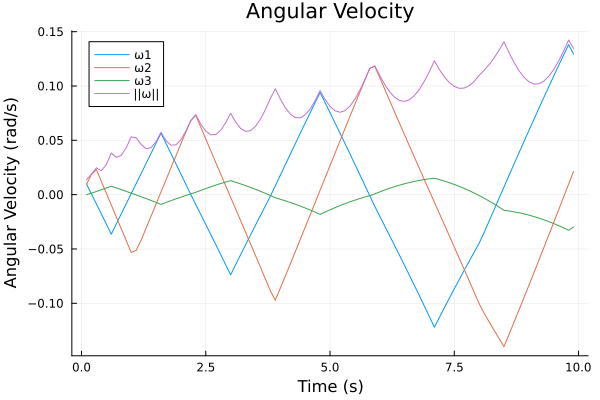

In [441]:
w_hist = [Vector([x.angular_velocity; norm(x.angular_velocity)]) for x in hist]
w_hist = SP.vec_to_mat(w_hist)
plot(time, w_hist, title="Angular Velocity", xlabel="Time (s)", ylabel="Angular Velocity (rad/s)", labels=["ω1" "ω2" "ω3" "||ω||"])

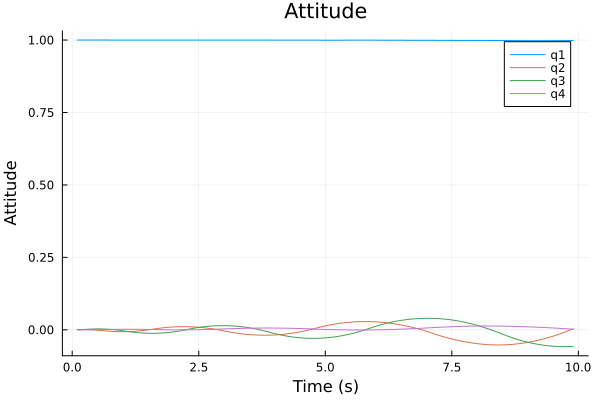

In [442]:
q_hist = [Vector(x.attitude) for x in hist]
q_hist = SP.vec_to_mat(q_hist)
plot(time, q_hist, title="Attitude", xlabel="Time (s)", ylabel="Attitude", labels=["q1" "q2" "q3" "q4"])